# NLP tf-idf pipeline with scikit-learn

In [1]:
%matplotlib inline
from tqdm import tqdm
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import pandas as pd

### Import other utility functions for benchmarking purposes 

In [2]:
from utils import SimpleTimer, ResultsLogger, visualize_data

## Benchmarking Code

### Helper functions

In [3]:
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english')) # converting the list to set will decrease latency in the pandas apply function: O(1) lookup
PUNCTUATIONS = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.',
                '/', '\\', ':', ';', '<', '=', '>', '?', '@', '[', ']', '^',
                '_', '`', '{', '|', '}', '\t','\n', "'", ",", '~' , '—']

def read_data(parquet_path):
    data = pd.read_parquet(parquet_path, columns=["review_body"])
    return data


def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS):
    data = data[data[column_name].notna()]
    # from https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
    transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
    data.loc[:,column_name] = (data[column_name].str.lower()
                           .str.translate(transtable)
                           .str.strip())
    data.loc[:,column_name] = data[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))                    
    return data


def hashing_vectorizer(data, column_name):
    vectorizer = HashingVectorizer(stop_words=None, preprocessor=None)
    hashing_vectorized = vectorizer.fit_transform(data[column_name])
    return hashing_vectorized


def tfidf_transformer(hashing_vectorized, column_name):
    transformer = TfidfTransformer()
    result = transformer.fit_transform(hashing_vectorized)
    return result


def execute_full_pipeline(n, i, parquet_path):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(parquet_path)
    sample_record["data_read"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        data = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS)
    sample_record["data_preprocessing"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data,"review_body")
    sample_record["hashing_vectorizer"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, "review_body")
    sample_record["tfidf_transformer"]=timer.elapsed/1e9

    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, result, sample_record


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.csv"):
    """
    Main function to perform the performance sweep
    """
    results_logger = ResultsLogger(result_path)
    for n in worker_counts: 
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, parquet_path)
            sample_record["overall"]=overalltimer.elapsed/1e9
            sample_record["nrows"]=data.shape[0]
            sample_record["n_workers"]=n
            sample_record["sample_run"]=i
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed/1e9}s")
            results_logger.log(sample_record)
    results_logger.write()

In [5]:
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 3
worker_counts = [1]
result_path = f"./results/result_poc_nlp_sklearn_{dataset}.csv"

In [6]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples,result_path=result_path)

  0%|                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Workers:1, Sample Run:0, Finished loading data in 27.176626497s
Workers:1, Sample Run:0, Finished preprocessing data in 1241.842861926s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 731.965263292s
Workers:1, Sample Run:0, Finished fitting IDF Transformer in 123.351881592s
Workers:1, Sample Run:0, Finished executing full pipeline in 2124.653676701s

 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1/3 [35:24<1:10:49, 2124.65s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2/3 [1:10:27<35:11, 2111.69s/it]

Workers:1, Sample Run:1, Finished loading data in 26.745783126s
Workers:1, Sample Run:1, Finished preprocessing data in 1239.419621929s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 715.500205747s
Workers:1, Sample Run:1, Finished fitting IDF Transformer in 120.634073774s
Workers:1, Sample Run:1, Finished executing full pipeline in 2102.609042801s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [1:45:45<00:00, 2115.24s/it]

Workers:1, Sample Run:2, Finished loading data in 29.64475292s
Workers:1, Sample Run:2, Finished preprocessing data in 1242.092643499s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 719.101140476s
Workers:1, Sample Run:2, Finished fitting IDF Transformer in 127.356223578s
Workers:1, Sample Run:2, Finished executing full pipeline in 2118.43830324s


CPU times: user 1h 43min 22s, sys: 11min 39s, total: 1h 55min 2s
Wall time: 1h 46min 12s


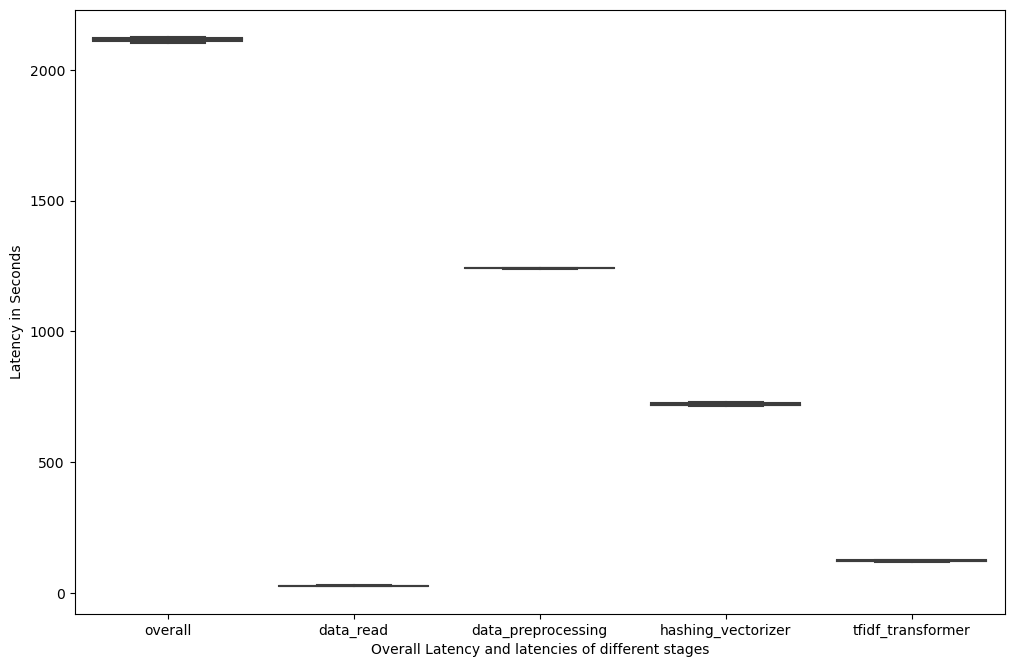

In [7]:
data, melt_data = visualize_data(result_path)    

In [8]:
data

,Unnamed: 0,overall,data_read,hashing_vectorizer,tfid_transformer,data_preprocessing,nrows,tfidf_transformer,n_workers,sample_run
0,0,2124.653677,27.176626,731.965263,0,1241.842862,20725971,123.351882,1,0
1,1,2102.609043,26.745783,715.500206,0,1239.419622,20725971,120.634074,1,1
2,2,2118.438303,29.644753,719.101140,0,1242.092643,20725971,127.356224,1,2


In [9]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupy

Unnamed: 0                 overall                   data_read  \
                mean  std count         mean        std count       mean   
n_workers                                                                  
1                  1  1.0     3  2115.233674  11.366341     3  27.855721   

                          hashing_vectorizer  ... data_preprocessing  \
                std count               mean  ...              count   
n_workers                                     ...                      
1          1.564252     3          722.18887  ...                  3   

              nrows            tfidf_transformer                 sample_run  \
               mean  std count              mean       std count       mean   
n_workers                                                                     
1          20725971  0.0     3        123.780726  3.381532     3          1   

                      
           std count  
n_workers             
1          1.0     3  

[1 rows x 27 columns]